In [57]:
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotnine as pn
from scipy.stats import ranksums
from datetime import datetime
from sklearn.metrics import r2_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [4]:
pn.theme_set(pn.theme_bw())
pn.theme_update(dpi=150)

In [5]:
# Files relevant to the GTEx analysis
run_name = 'aparent2_ensembl_deltapdui_wide'
# enformer variant effect on GTEx variants
aparent2_path = f'/s/project/promoter_prediction/kipoi_expression_prediction/veff/aparent2.parquet/run={run_name}'
# GTEx variants
variant_path = '/s/project/rep/processed/training_results_v15/gtex_v8_old_dna/private_variants.parquet/rare_variants.vcf.parquet/**/*.parquet'
# abexp benchmark dataset
gtex_benchmark_with_annotation_path = "/s/project/rep/processed/training_results_v15/gtex_benchmark_with_annotation.parquet/*.parquet"

## Analysis

In [6]:
veff_transcript_ldf = (pl.scan_parquet(Path(aparent2_path) / '*.parquet').
                       select(pl.col(['tissue', 'gene_id', 'transcript_id', 'pas_id', 'cse_pos', 'pas_pos',]), 
                              pl.col('strand').cast(pl.Enum(['-', '+'])),
                              pl.col(['chrom', 'variant_start', 'variant_end', 'ref', 'alt', 'veff_score', 'ref_score', 'alt_score'])).
                       rename({'gene_id': 'gene', 'transcript_id': 'transcript'}).
                       with_columns(pl.col('gene').str.replace(r'([^\.]+)\..+$', "${1}").alias('gene'),
                                    pl.col('transcript').str.replace(r'([^\.]+)\..+$', "${1}").alias('transcript')))


# It is possible that a gene comes multiple times (different versions)

In [7]:
variant_ldf = pl.scan_parquet(variant_path, hive_partitioning=True).select(['sampleId', 'chrom', 'start', 'end', 'ref', 'alt']).rename({'sampleId': 'individual',
                                                                                                                'start': 'variant_start',
                                                                                                                'end': 'variant_end'})

In [8]:
training_benchmark_ldf = (pl.scan_parquet(gtex_benchmark_with_annotation_path)
                          .select(['gene', 'individual', 'tissue', 'FDR', 
                                   'mu', 'zscore', 'l2fc', 'is_obvious_outlier'])
                          .unique()
                          .rename({'l2fc': 'l2fc_outrider'})
                          .with_columns((pl.when(pl.col('FDR') > 0.2)
                                         .then(pl.lit('normal'))
                                         .otherwise(
                                             pl.when(pl.col('zscore') > 0)
                                             .then(pl.lit('overexpressed'))
                                             .otherwise(
                                                 pl.when(pl.col('zscore') < 0)
                                                 .then(pl.lit('underexpressed'))
                                                 # this should never be the case
                                                 .otherwise(pl.lit('CHECK'))
                                             ))).cast(pl.Enum(['underexpressed', 'normal', 'overexpressed'])).alias('outlier_state')))

### What is the aparent2 variant-effect-score distribution around the CSE?

In [43]:
upstream=70
downstream=130

# join variants with enformer_veff on veff
veff_variant_ldf = variant_ldf.join(veff_transcript_ldf, how='inner', on=['chrom', 'variant_start', 'variant_end', 'ref', 'alt'])
# calculate variant position relative to the tss: rel_var_pos
veff_variant_ldf = veff_variant_ldf.with_columns((pl.when(pl.col('strand') == '+')
                                 .then(pl.col('variant_start') - pl.col('cse_pos'))
                                 .otherwise(pl.col('cse_pos') - pl.col('variant_start'))
                            ).alias('rel_var_pos'))
# filter out variants far from the CSE
veff_variant_ldf = veff_variant_ldf.filter((pl.col('rel_var_pos') >= -upstream) & (pl.col('rel_var_pos') < downstream))
veff_variant_ldf = (veff_variant_ldf.
                              select(['individual', 'chrom', 'variant_start', 'variant_end', 'ref', 'alt', 'tissue', 'gene',
                                      'transcript', 'pas_id', 'strand', 'veff_score', 'ref_score', 'alt_score', 'rel_var_pos']))

# join outrider with variants on individual
veff_outrider_ldf = (veff_variant_ldf.join(training_benchmark_ldf, how='inner', on=['individual', 'gene', 'tissue']).
                               select(['gene', 'transcript', 'pas_id', 'tissue', 'individual', 'chrom', 'variant_start', 'variant_end', 'ref', 'alt',
                                       'rel_var_pos', 'outlier_state', 'zscore', 'FDR', 'veff_score',
                                       'l2fc_outrider', 'mu', 'is_obvious_outlier'])) 

In [44]:
veff_outrider_df = veff_outrider_ldf.collect()

In [45]:
veff_outrider_df

gene,transcript,pas_id,tissue,individual,chrom,variant_start,variant_end,ref,alt,rel_var_pos,outlier_state,zscore,FDR,veff_score,l2fc_outrider,mu,is_obvious_outlier
str,str,str,str,str,str,i64,i64,str,str,i64,enum,f32,f64,f64,f32,f32,bool
"""ENSG00000142409""","""ENST00000610935""","""chr19:56598731:-""","""Esophagus - Gastroesophageal Junction""","""GTEX-11VI4""","""chr19""",56598818,56598819,"""C""","""T""",-57,"""normal""",0.460568,1.0,-0.000406,0.045332,633.738953,false
"""ENSG00000048540""","""ENST00000545436""","""chr12:16713414:-""","""Lung""","""GTEX-QMRM""","""chr12""",16713511,16713512,"""C""","""G""",-67,"""normal""",0.652103,1.0,0.0,0.154845,3198.491455,false
"""ENSG00000068323""","""ENST00000495940""","""chrX:48888025:-""","""Colon - Transverse""","""GTEX-WYVS""","""chrX""",48887957,48887958,"""C""","""A""",98,"""normal""",-0.822627,1.0,0.006359,-0.078756,1961.246216,false
"""ENSG00000164181""","""ENST00000425382""","""chr5:60047618:-""","""Adipose - Subcutaneous""","""GTEX-ZLFU""","""chr5""",60047681,60047682,"""C""","""T""",-33,"""normal""",-0.765469,1.0,0.038606,-0.200675,1142.489624,false
"""ENSG00000198089""","""ENST00000450787""","""chr22:31957318:+""","""Brain - Cortex""","""GTEX-OHPN""","""chr22""",31957387,31957388,"""G""","""A""",99,"""normal""",0.165079,1.0,0.0,0.017104,940.768372,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ENSG00000065000""","""ENST00000589369""","""chr19:2102235:-""","""Brain - Hippocampus""","""GTEX-1F6I4""","""chr19""",2102316,2102317,"""G""","""C""",-51,"""normal""",-0.063819,1.0,-0.000005,-0.004015,5335.833008,false
"""ENSG00000107099""","""ENST00000483757""","""chr9:381386:+""","""Whole Blood""","""GTEX-QLQ7""","""chr9""",381320,381323,"""CTT""","""C""",-36,"""normal""",-1.191796,1.0,-0.003147,-0.181145,4852.728027,false
"""ENSG00000260007""","""ENST00000637888""","""chr15:68476369:-""","""Thyroid""","""GTEX-ZYW4""","""chr15""",68476447,68476451,"""TTGA""","""T""",-48,"""normal""",-0.030203,1.0,0.001879,-0.005842,764.091736,false


In [49]:
agg_veff_df = veff_outrider_df.with_columns(
    top=(pl.col('veff_score').abs() == pl.col('veff_score').abs().max())
    .over(['gene', 'tissue', 'individual']),
).filter(pl.col('top')).group_by(['gene', 'tissue', 'individual']).agg(
    pl.exclude('top').first()
)

In [56]:
multivariant_df = veff_outrider_df.group_by(['gene', 'tissue', 'individual']).agg(
    veff_score_list=pl.col('veff_score'),
    pas_id_list=pl.col('pas_id'),
    rel_var_pos_list=pl.col('rel_var_pos'),
).filter(pl.col('veff_score_list').list.len() > 1).select(['gene', 'tissue', 'individual'])

In [62]:
r2_score(agg_veff_df['zscore'], agg_veff_df['veff_score'],)

0.0007114037578899168

0.0007114037578899168


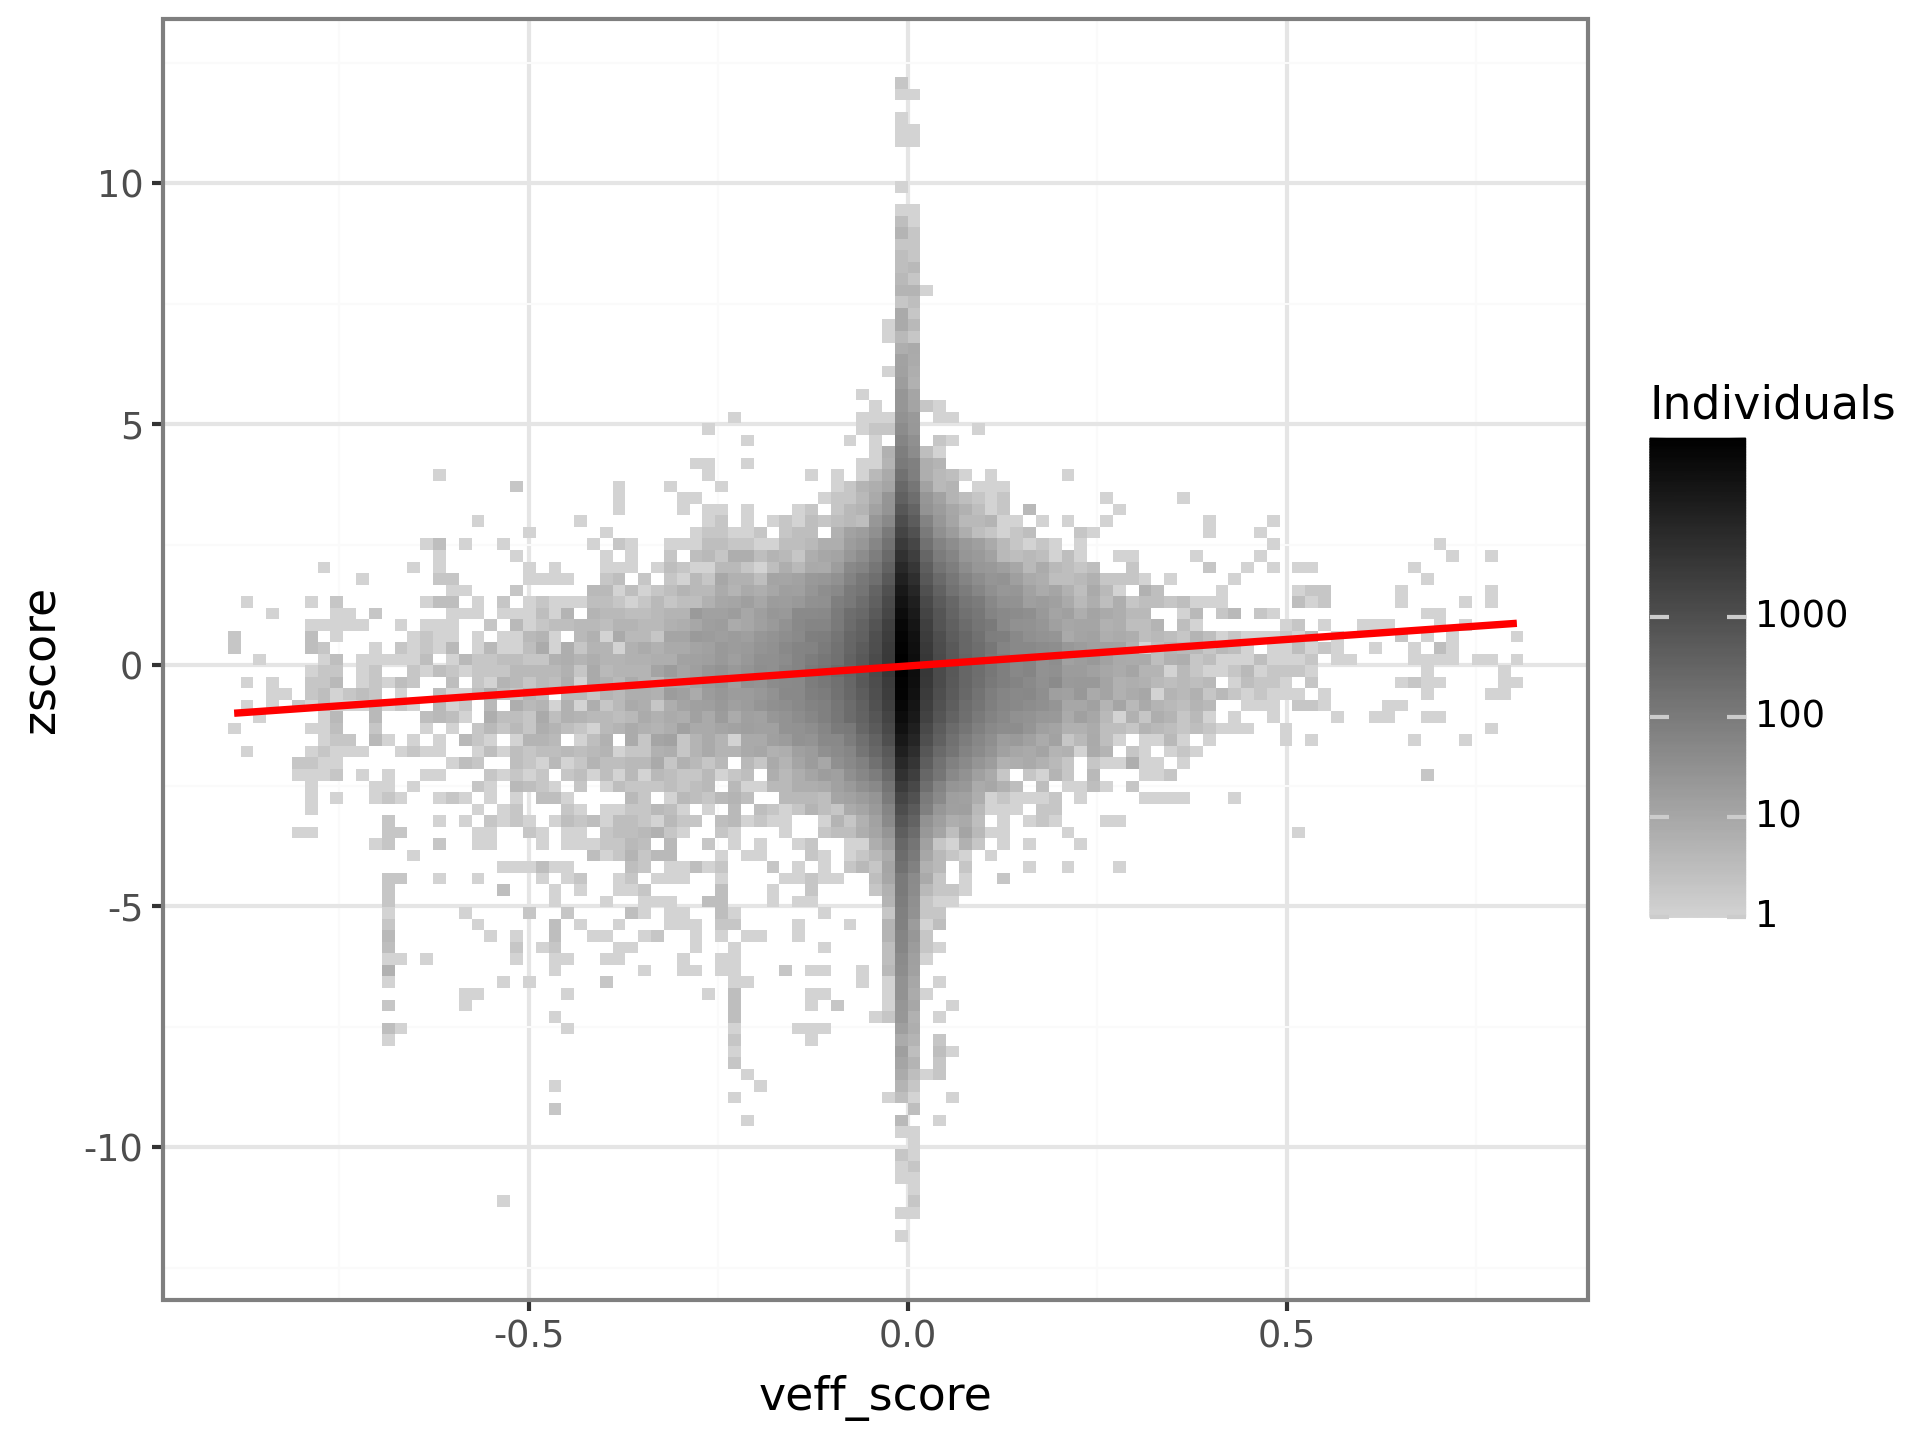

In [63]:
print(r2_score(agg_veff_df['zscore'], agg_veff_df['veff_score'],))
(pn.ggplot(agg_veff_df, pn.aes(x='veff_score', y='zscore'))
 + pn.geom_bin2d(bins=100)
 + pn.geom_smooth(method="lm", color="red") 
 + pn.scale_fill_gradient(name = "Individuals", trans = "log10", breaks=[1, 10, 100, 1000], low="lightgrey", high="black"))

0.0007468880309708936


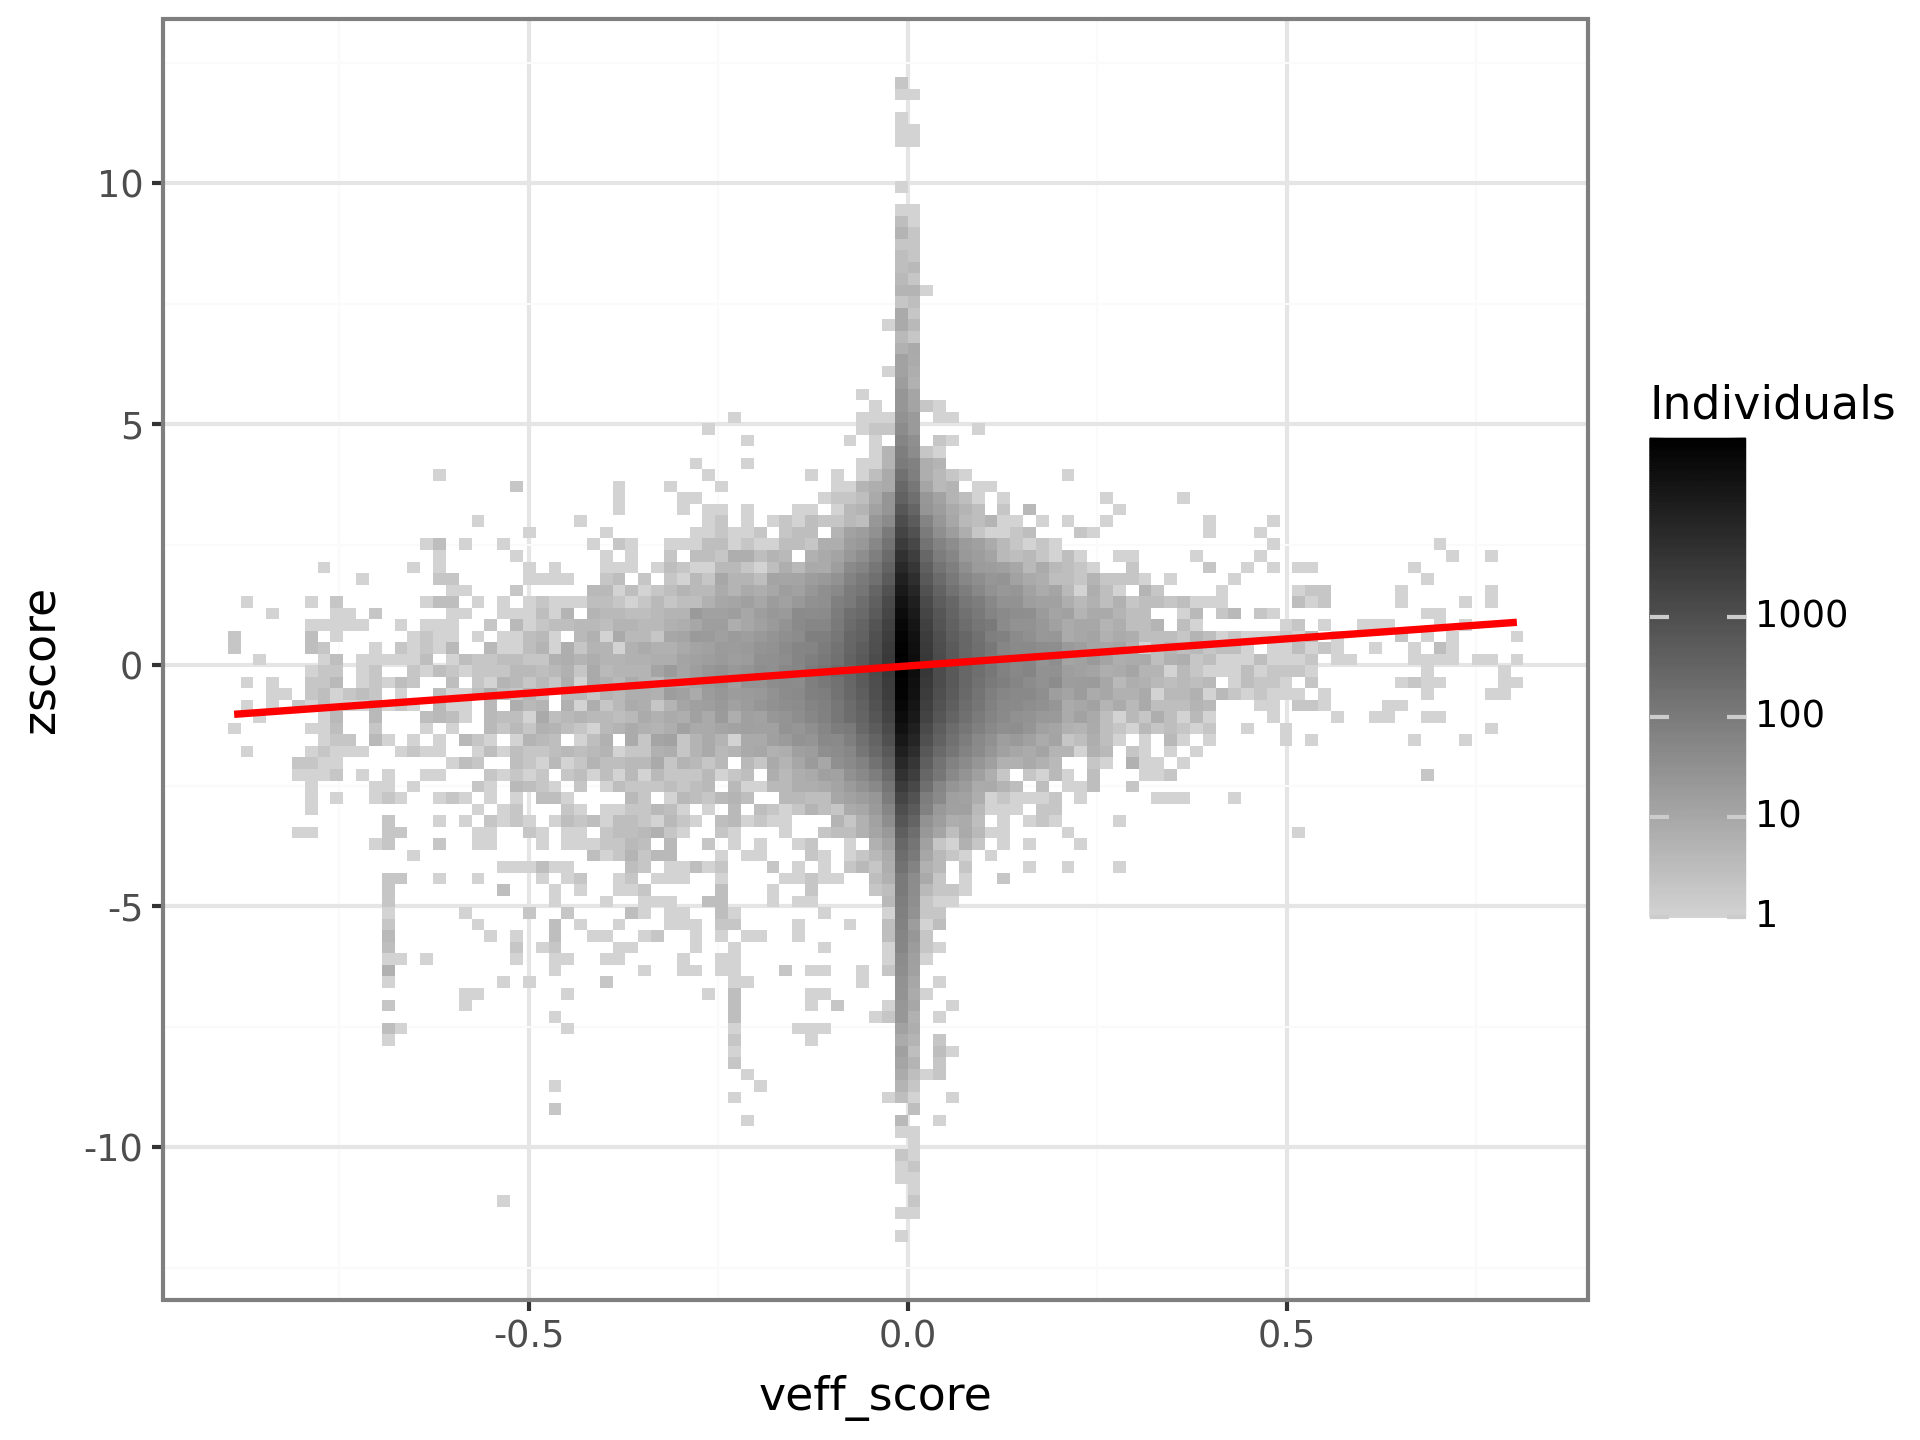

In [67]:
tmp = agg_veff_df.join(multivariant_df, on=['gene', 'tissue', 'individual'], how='anti')
print(r2_score(tmp['zscore'], tmp['veff_score'],))
(pn.ggplot(tmp, pn.aes(x='veff_score', y='zscore'))
 + pn.geom_bin2d(bins=100)
 + pn.geom_smooth(method="lm", color="red") 
 + pn.scale_fill_gradient(name = "Individuals", trans = "log10", breaks=[1, 10, 100, 1000], low="lightgrey", high="black"))

In [80]:
agg_veff_df.filter((pl.col('gene') == 'ENSG00000108551') & (pl.col('individual') == 'GTEX-ZVT3')).sort('zscore')

gene,tissue,individual,transcript,pas_id,chrom,variant_start,variant_end,ref,alt,rel_var_pos,outlier_state,zscore,FDR,veff_score,l2fc_outrider,mu,is_obvious_outlier
str,str,str,str,str,str,i64,i64,str,str,i64,enum,f32,f64,f64,f32,f32,bool
"""ENSG00000108551""","""Liver""","""GTEX-ZVT3""","""ENST00000225688""","""chr17:17397750:-""","""chr17""",17397763,17397781,"""ATTATTTTATTGTATATT""","""A""",17,"""normal""",-1.717216,1.0,-0.872766,-1.61728,1177.096924,false
"""ENSG00000108551""","""Stomach""","""GTEX-ZVT3""","""ENST00000225688""","""chr17:17397750:-""","""chr17""",17397763,17397781,"""ATTATTTTATTGTATATT""","""A""",17,"""normal""",-1.269846,1.0,-0.882962,-0.906126,2635.727539,false
"""ENSG00000108551""","""Brain - Frontal Cortex (BA9)""","""GTEX-ZVT3""","""ENST00000225688""","""chr17:17397750:-""","""chr17""",17397763,17397781,"""ATTATTTTATTGTATATT""","""A""",17,"""normal""",-0.99052,1.0,-0.858783,-0.2871,2386.902588,false
"""ENSG00000108551""","""Brain - Caudate (basal ganglia)""","""GTEX-ZVT3""","""ENST00000225688""","""chr17:17397750:-""","""chr17""",17397763,17397781,"""ATTATTTTATTGTATATT""","""A""",17,"""normal""",-0.894116,1.0,-0.839344,-0.319981,633.143372,false
"""ENSG00000108551""","""Heart - Atrial Appendage""","""GTEX-ZVT3""","""ENST00000225688""","""chr17:17397750:-""","""chr17""",17397763,17397781,"""ATTATTTTATTGTATATT""","""A""",17,"""normal""",-0.846934,1.0,-0.873185,-0.590014,3810.322998,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ENSG00000108551""","""Nerve - Tibial""","""GTEX-ZVT3""","""ENST00000225688""","""chr17:17397750:-""","""chr17""",17397763,17397781,"""ATTATTTTATTGTATATT""","""A""",17,"""normal""",0.36694,1.0,-0.884753,0.116867,464.70517,false
"""ENSG00000108551""","""Skin - Sun Exposed (Lower leg)""","""GTEX-ZVT3""","""ENST00000225688""","""chr17:17397750:-""","""chr17""",17397763,17397781,"""ATTATTTTATTGTATATT""","""A""",17,"""normal""",0.53147,1.0,-0.885593,0.172984,980.028625,false
"""ENSG00000108551""","""Muscle - Skeletal""","""GTEX-ZVT3""","""ENST00000225688""","""chr17:17397750:-""","""chr17""",17397763,17397781,"""ATTATTTTATTGTATATT""","""A""",17,"""normal""",0.587657,1.0,-0.883169,0.247506,802.602966,false


In [76]:
agg_veff_df.join(multivariant_df, on=['gene', 'tissue', 'individual'], how='anti'). \
    filter((pl.col('veff_score') < -0.5) & (pl.col('zscore') > 0)). \
    sort('zscore')

gene,tissue,individual,transcript,pas_id,chrom,variant_start,variant_end,ref,alt,rel_var_pos,outlier_state,zscore,FDR,veff_score,l2fc_outrider,mu,is_obvious_outlier
str,str,str,str,str,str,i64,i64,str,str,i64,enum,f32,f64,f64,f32,f32,bool
"""ENSG00000108551""","""Brain - Cortex""","""GTEX-ZVT3""","""ENST00000225688""","""chr17:17397750:-""","""chr17""",17397763,17397781,"""ATTATTTTATTGTATATT""","""A""",17,"""normal""",0.00266,1.0,-0.855521,-0.013062,4630.745605,false
"""ENSG00000100647""","""Thyroid""","""GTEX-133LE""","""ENST00000342745""","""chr14:70181860:+""","""chr14""",70181837,70181838,"""A""","""T""",7,"""normal""",0.00899,1.0,-0.521029,-0.001385,4693.505371,false
"""ENSG00000144711""","""Breast - Mammary Tissue""","""GTEX-R55D""","""ENST00000273221""","""chr3:12938718:-""","""chr3""",12938732,12938733,"""T""","""C""",16,"""normal""",0.036493,1.0,-0.603021,0.001123,2577.992432,false
"""ENSG00000145016""","""Artery - Aorta""","""GTEX-T6MN""","""ENST00000273582""","""chr3:197398263:-""","""chr3""",197398294,197398299,"""GATTT""","""G""",-1,"""normal""",0.048373,1.0,-0.585876,0.002159,1345.983032,false
"""ENSG00000137766""","""Brain - Frontal Cortex (BA9)""","""GTEX-11DYG""","""ENST00000539562""","""chr15:54919606:+""","""chr15""",54919588,54919589,"""A""","""C""",12,"""normal""",0.05404,1.0,-0.525654,-0.003135,7364.987793,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ENSG00000001167""","""Artery - Coronary""","""GTEX-13FHP""","""ENST00000341376""","""chr6:41070141:+""","""chr6""",41070117,41070123,"""ATAAAG""","""A""",6,"""normal""",2.736682,1.0,-0.504424,0.345636,744.251831,false
"""ENSG00000001167""","""Pituitary""","""GTEX-13FHP""","""ENST00000341376""","""chr6:41070141:+""","""chr6""",41070117,41070123,"""ATAAAG""","""A""",6,"""normal""",3.020618,1.0,-0.566167,0.316948,1176.658203,false
"""ENSG00000101974""","""Cells - EBV-transformed lymphocytes""","""GTEX-ZPCL""","""ENST00000327569;ENST00000361648;ENST00000433868""","""chrX:138808507:-""","""chrX""",138808530,138808531,"""T""","""C""",7,"""normal""",3.635425,0.988978,-0.517393,0.416036,1222.152954,false


In [148]:
ref_path = '/s/project/promoter_prediction/kipoi_expression_prediction/process/aparent2/reference/ensembl_GRCh37.parquet'
alt_path = '/s/project/promoter_prediction/kipoi_expression_prediction/process/aparent2/alternative/ensembl_GRCh37__gtexv8_70-134.parquet'

In [156]:
seq_start, seq_end = pl.scan_parquet(ref_path).filter((pl.col('pas_id') == "chr17:17397750:-")).select(['seq_start', 'seq_end']).collect().row(0)
cse_pos = pl.scan_parquet(ref_path).filter((pl.col('pas_id') == "chr17:17397750:-")).select('cse_pos').collect().item()
# bug in kipoiseq, therfore seq_end - 1
# real seq_end 1-based: seq_end - 1
seq_interval = list(range(seq_start, seq_end - 1))

In [149]:
ref_scores = pl.scan_parquet(ref_path).filter((pl.col('pas_id') == "chr17:17397750:-")).select('cleavage_prob_bp').collect().item()[:len(seq_interval)]
alt_scores = pl.scan_parquet(alt_path).filter((pl.col('pas_id') == "chr17:17397750:-") & (pl.col('variant_start') == 17397763) & (pl.col('variant_end') == 17397781)).select('cleavage_prob_bp').collect().item()[:len(seq_interval)]

In [152]:
tracks_df = pl.concat([pl.DataFrame({'pos': seq_interval, 'score': ref_scores, 'type': 'ref'}),
                       pl.DataFrame({'pos': seq_interval, 'score': alt_scores, 'type': 'alt'})])

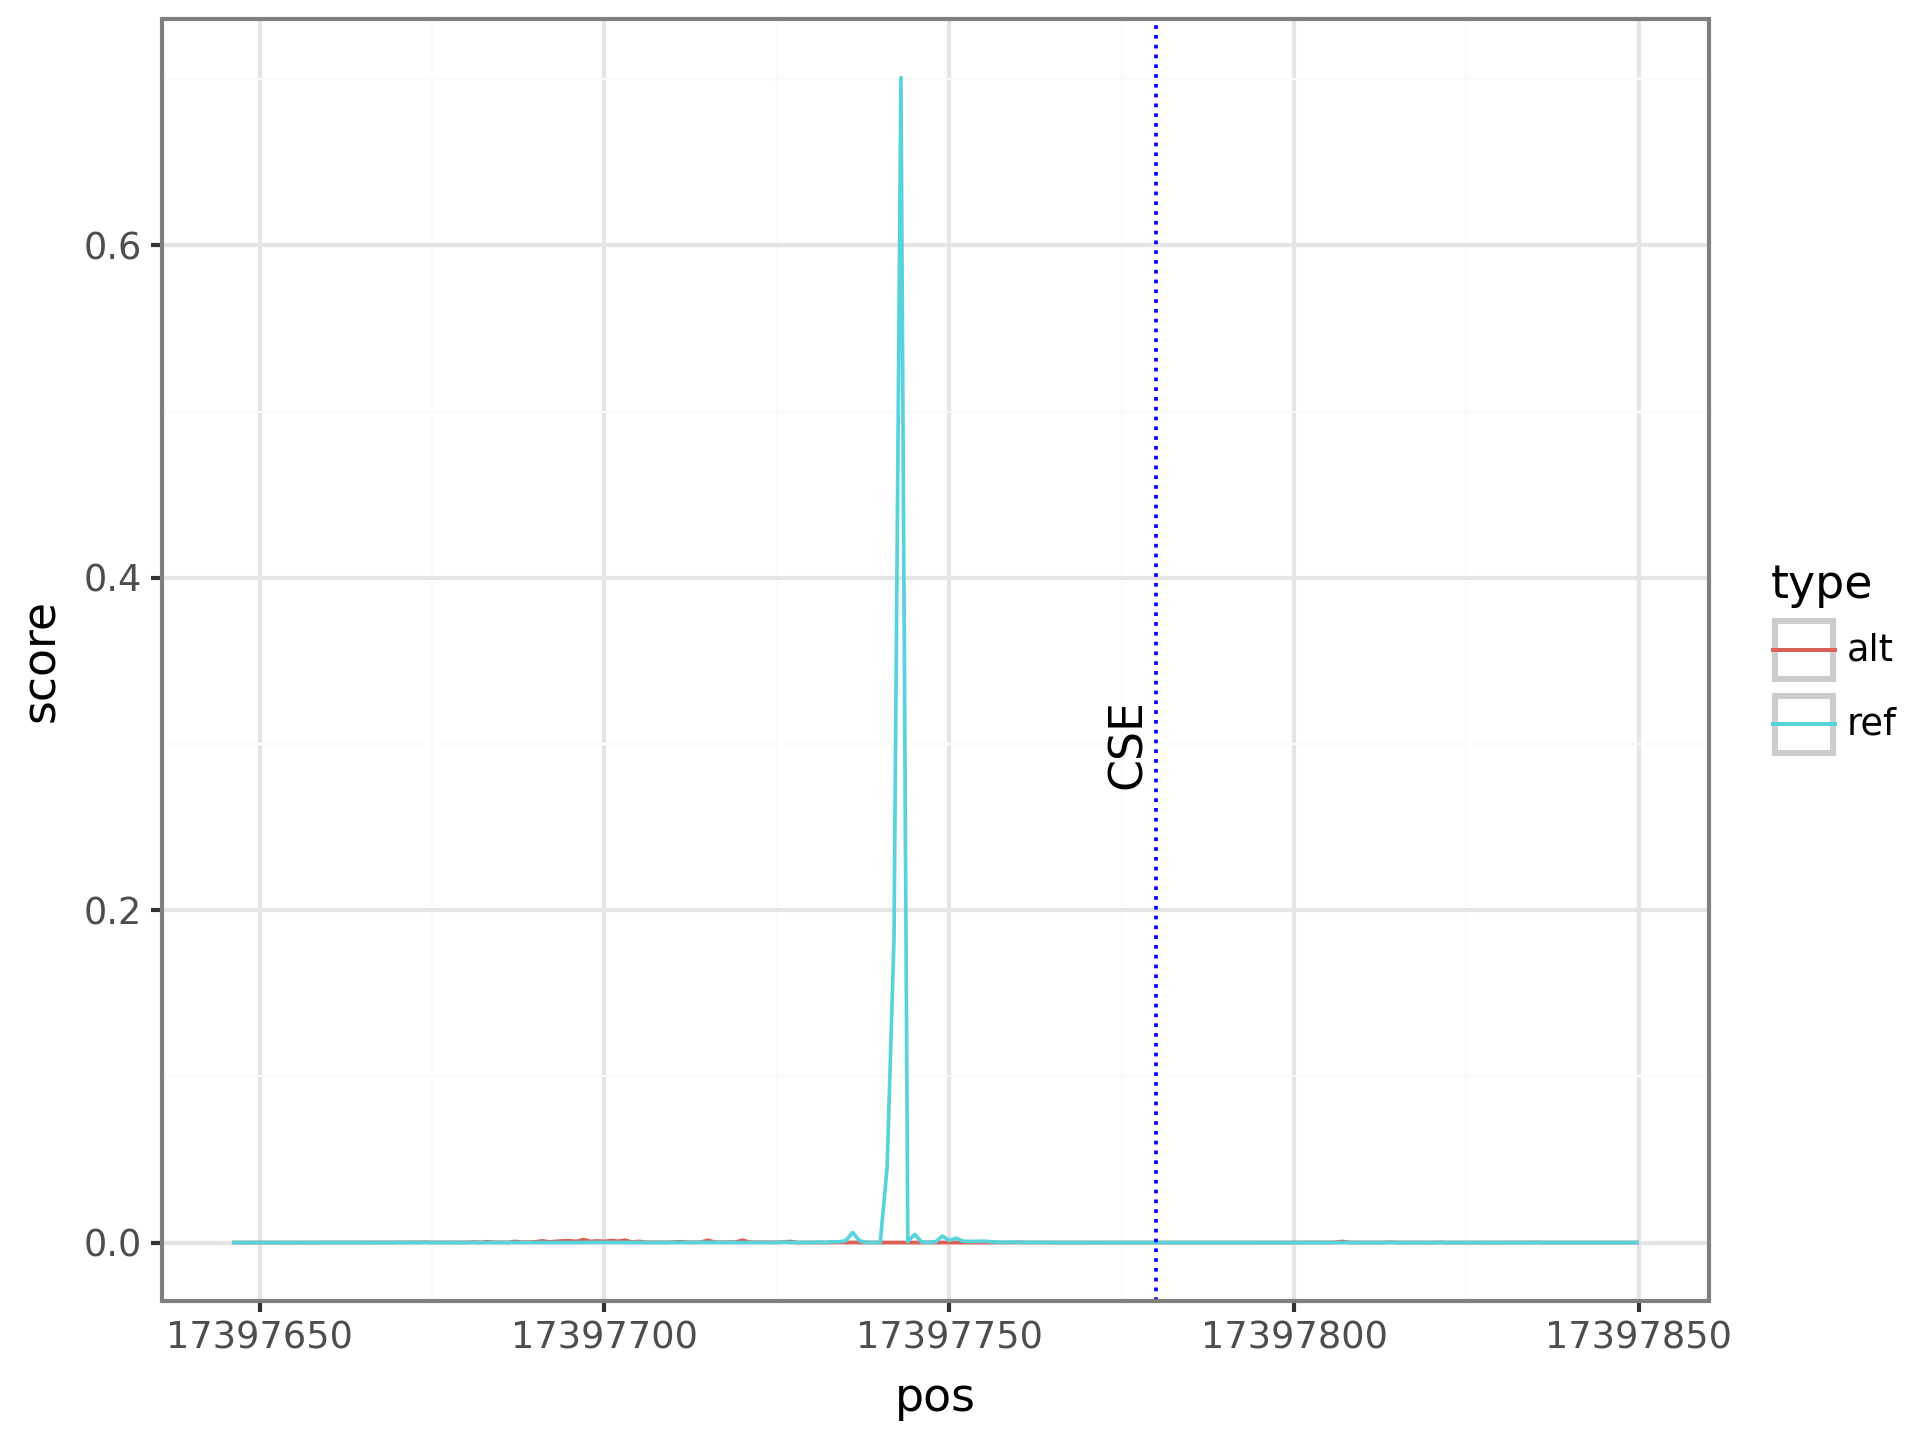

In [168]:
pn.ggplot(tracks_df, pn.aes(x='pos', y='score', color='type')) + pn.geom_line() + pn.geom_vline(xintercept = cse_pos, linetype="dotted", color = "blue") + pn.annotate("text", x=cse_pos - 4, y=0.3, label="CSE", angle=90)